<a href="https://colab.research.google.com/github/partha1189/ml/blob/master/catsvSDogsTranferLearningDropoutInceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-08-03 13:42:36--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   104MB/s    in 0.8s    

2020-08-03 13:42:37 (104 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
!ls -l /tmp/

total 85852
-rw-r--r-- 1 root root 87910968 Mar 28  2018 inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


In [4]:
from tensorflow.keras.applications import InceptionV3

In [5]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [6]:
pre_trained_model = InceptionV3(include_top=False,
                                weights=None,
                                input_shape=(150, 150, 3))

In [7]:
pre_trained_model.load_weights(local_weights_file)

In [8]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [9]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
last_layer = pre_trained_model.get_layer('mixed7')

In [11]:
last_layer.output_shape

(None, 7, 7, 768)

In [12]:
last_output = last_layer.output

In [13]:
from tensorflow.keras.optimizers import RMSprop

In [14]:
x = layers.Flatten()(last_output)

In [15]:
x = layers.Dense(1024, activation='relu')(x)

In [16]:
x = layers.Dropout(0.2)(x)

In [17]:
x = layers.Dense(1, activation='sigmoid')(x)

In [18]:
model = Model(pre_trained_model.input, x)

In [19]:
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

--2020-08-03 13:46:24--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   114MB/s    in 0.6s    

2020-08-03 13:46:25 (114 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [21]:
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [22]:
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 24s - loss: 0.3505 - accuracy: 0.8650 - val_loss: 0.2114 - val_accuracy: 0.9180
Epoch 2/20
100/100 - 22s - loss: 0.2496 - accuracy: 0.9035 - val_loss: 0.1715 - val_accuracy: 0.9390
Epoch 3/20
100/100 - 23s - loss: 0.1904 - accuracy: 0.9255 - val_loss: 0.0930 - val_accuracy: 0.9610
Epoch 4/20
100/100 - 22s - loss: 0.1934 - accuracy: 0.9305 - val_loss: 0.0986 - val_accuracy: 0.9650
Epoch 5/20
100/100 - 23s - loss: 0.1920 - accuracy: 0.9325 - val_loss: 0.1300 - val_accuracy: 0.9470
Epoch 6/20
100/100 - 22s - loss: 0.1907 - accuracy: 0.9390 - val_loss: 0.1319 - val_accuracy: 0.9620
Epoch 7/20
100/100 - 22s - loss: 0.1666 - accuracy: 0.9490 - val_loss: 0.1019 - val_accuracy: 0.9700
Epoch 8/20
100/100 - 22s - loss: 0.1699 - accuracy: 0.9395 - val_loss: 0.1008 - val_accuracy: 0.9680
Epoch 9/20
100/100 - 22s - loss: 0.1586 - accuracy: 0.9485 - val_loss: 0.1337 - val_accuracy: 0.9620
Epoch 10/20
100/100 - 21s - loss: 0.1533 - accuracy: 0.9555 - val_loss: 0.1052 - val_accura

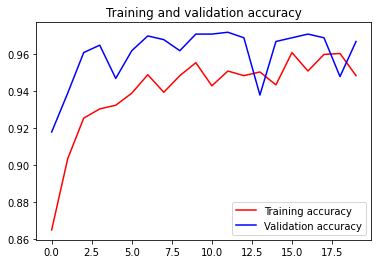

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()